# Deep Learning Models – Train & Evaluate
**Models:** Dense Neural Network (DNN), 1D-CNN, LSTM  
**Target:** `stress_level` (0=natural, 1=low, 2=mid, 3=high)

## 1. Import Required Libraries

In [31]:
import os, json, warnings

import numpy as np
import pandas as pd
import joblib
from pathlib import Path
from copy import deepcopy

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings("ignore")

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch version:", torch.__version__)
print("Device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

PyTorch version: 2.10.0+cpu
Device: cpu


In [32]:
# Configuration
ROOT = Path.cwd()
MODEL_DIR = ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)
STATIC_DIR = ROOT / "static"
STATIC_DIR.mkdir(exist_ok=True)

STRESS_NAMES = ["natural", "lowlevel", "midlevel", "highlevel"]
NUM_CLASSES = 4
EPOCHS = 300          # More epochs (early stopping will handle it)
BATCH_SIZE = 8        # Smaller batch for small dataset
N_FOLDS = 5           # K-Fold cross-validation
LABEL_SMOOTH = 0.1    # Label smoothing
WEIGHT_DECAY = 1e-3   # L2 regularization
NOISE_STD = 0.05      # Gaussian noise for augmentation
N_AUGMENT = 3         # Number of augmented copies per sample

print(f"ROOT: {ROOT}")
print(f"MODEL_DIR: {MODEL_DIR}")
print(f"STATIC_DIR: {STATIC_DIR}")
print(f"Config: EPOCHS={EPOCHS}, BATCH_SIZE={BATCH_SIZE}, N_FOLDS={N_FOLDS}")

ROOT: /home/noman/MyFiles/AI/Research Paper/raw_data
MODEL_DIR: /home/noman/MyFiles/AI/Research Paper/raw_data/models
STATIC_DIR: /home/noman/MyFiles/AI/Research Paper/raw_data/static
Config: EPOCHS=300, BATCH_SIZE=8, N_FOLDS=5


## 2. Load and Inspect the Dataset

In [33]:
# Load the processed dataset
df = pd.read_csv(ROOT / "processed_dataset.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
df.head()

Dataset shape: (120, 81)

Column names:
['EEG_TP9_mean', 'EEG_TP9_std', 'EEG_TP9_min', 'EEG_TP9_max', 'EEG_TP9_median', 'EEG_TP9_skew', 'EEG_TP9_kurtosis', 'EEG_AF7_mean', 'EEG_AF7_std', 'EEG_AF7_min', 'EEG_AF7_max', 'EEG_AF7_median', 'EEG_AF7_skew', 'EEG_AF7_kurtosis', 'EEG_AF8_mean', 'EEG_AF8_std', 'EEG_AF8_min', 'EEG_AF8_max', 'EEG_AF8_median', 'EEG_AF8_skew', 'EEG_AF8_kurtosis', 'EEG_TP10_mean', 'EEG_TP10_std', 'EEG_TP10_min', 'EEG_TP10_max', 'EEG_TP10_median', 'EEG_TP10_skew', 'EEG_TP10_kurtosis', 'EEG_AUX_L_mean', 'EEG_AUX_L_std', 'EEG_AUX_L_min', 'EEG_AUX_L_max', 'EEG_AUX_L_median', 'EEG_AUX_L_skew', 'EEG_AUX_L_kurtosis', 'EEG_AUX_R_mean', 'EEG_AUX_R_std', 'EEG_AUX_R_min', 'EEG_AUX_R_max', 'EEG_AUX_R_median', 'EEG_AUX_R_skew', 'EEG_AUX_R_kurtosis', 'EEG_DRL_mean', 'EEG_DRL_std', 'EEG_DRL_min', 'EEG_DRL_max', 'EEG_DRL_median', 'EEG_DRL_skew', 'EEG_DRL_kurtosis', 'EEG_REF_mean', 'EEG_REF_std', 'EEG_REF_min', 'EEG_REF_max', 'EEG_REF_median', 'EEG_REF_skew', 'EEG_REF_kurtosis', 'ACC

,EEG_TP9_mean,EEG_TP9_std,EEG_TP9_min,EEG_TP9_max,EEG_TP9_median,EEG_TP9_skew,EEG_TP9_kurtosis,EEG_AF7_mean,EEG_AF7_std,EEG_AF7_min,...,ACC_Z_std,ACC_Z_min,ACC_Z_max,ACC_Z_median,ACC_Z_skew,ACC_Z_kurtosis,task,stress_level,stress_label,participant
0,34495.973774,425.248055,0.000000,35121.161952,34440.886610,-24.525585,1996.739863,33218.681656,447.659044,0.000000,...,0.004106,0.958,0.986,0.974,-0.188457,0.045613,Arithmetic,0,natural,1
1,4784.667376,1247.884626,1943.372422,6799.132442,5116.716637,-0.406030,-1.054502,11161.100071,1432.710628,7548.832303,...,0.010619,0.436,0.984,0.966,-35.965067,1665.681932,Arithmetic,0,natural,2
2,10416.587985,1629.202128,8633.987145,14319.734492,9555.974252,0.980290,-0.385080,8156.463594,1368.831166,6743.543654,...,0.010865,0.482,0.988,0.972,-31.543519,1291.021715,Arithmetic,0,natural,3
3,3227.577829,129.636637,0.000000,3703.818167,3205.083693,-0.177797,23.316549,8109.127702,114.684066,0.000000,...,0.003904,0.962,0.986,0.976,-0.205180,0.021682,Arithmetic,0,natural,4
4,32540.355822,917.439166,0.000000,34052.502698,32608.580006,-3.257783,54.516221,16250.237732,647.384306,0.000000,...,0.012426,0.000,0.990,0.972,-15.170497,1131.139968,Arithmetic,0,natural,5


In [34]:
# Inspect dataset info and statistics
print("Dataset Info:")
df.info()
print(f"\nStress level distribution:\n{df['stress_level'].value_counts().sort_index()}")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 81 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EEG_TP9_mean        120 non-null    float64
 1   EEG_TP9_std         120 non-null    float64
 2   EEG_TP9_min         120 non-null    float64
 3   EEG_TP9_max         120 non-null    float64
 4   EEG_TP9_median      120 non-null    float64
 5   EEG_TP9_skew        120 non-null    float64
 6   EEG_TP9_kurtosis    120 non-null    float64
 7   EEG_AF7_mean        120 non-null    float64
 8   EEG_AF7_std         120 non-null    float64
 9   EEG_AF7_min         120 non-null    float64
 10  EEG_AF7_max         120 non-null    float64
 11  EEG_AF7_median      120 non-null    float64
 12  EEG_AF7_skew        120 non-null    float64
 13  EEG_AF7_kurtosis    120 non-null    float64
 14  EEG_AF8_mean        120 non-null    float64
 15  EEG_AF8_std         120 non-null    float64

,EEG_TP9_mean,EEG_TP9_std,EEG_TP9_min,EEG_TP9_max,EEG_TP9_median,EEG_TP9_skew,EEG_TP9_kurtosis,EEG_AF7_mean,EEG_AF7_std,EEG_AF7_min,...,ACC_Y_kurtosis,ACC_Z_mean,ACC_Z_std,ACC_Z_min,ACC_Z_max,ACC_Z_median,ACC_Z_skew,ACC_Z_kurtosis,stress_level,participant
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,11308.719173,283.519906,-268.274950,12832.336167,11311.229084,-34.001366,5194.156315,12597.945722,346.264007,217.011597,...,5.640417,0.949480,0.006530,0.522450,0.965433,0.949783,-36.718137,4273.257877,1.500000,8.000000
std,13525.009194,347.406957,7152.152665,11932.372926,13521.426351,54.877463,7343.703630,12914.648733,539.371546,7920.442309,...,39.765850,0.152689,0.003395,0.438678,0.157695,0.152737,43.024671,5680.136005,1.122722,4.338609
min,-16333.477132,22.066492,-34417.976072,-1955.621178,-16332.777301,-166.286298,-1.468743,-17880.556313,29.446754,-27877.810940,...,-0.490563,0.000000,0.000000,0.000000,0.000000,0.000000,-101.661691,-0.120621,0.000000,1.000000
25%,1161.538934,72.239891,0.000000,1234.486846,1161.033426,-78.686197,0.768241,4446.750620,114.684066,0.000000,...,-0.051052,0.973105,0.003904,0.000000,0.986000,0.974000,-92.464112,0.124158,0.750000,4.000000
50%,7169.378137,153.023452,0.000000,7292.591905,7195.803263,-4.665595,744.783724,10921.795648,196.126616,0.000000,...,0.044822,0.974230,0.006513,0.489000,0.988000,0.974000,-15.170497,561.541779,1.500000,8.000000
75%,24420.220991,268.052933,0.000000,24657.198373,24353.795794,-0.289305,9234.779535,22785.191550,271.732669,0.000000,...,0.162678,0.975218,0.008292,0.960000,0.988000,0.976000,-0.098546,11002.598906,2.250000,12.000000
max,34495.973774,1629.202128,26558.812148,35121.161952,34440.886610,80.590811,28751.110286,33218.681656,4796.198044,28589.848112,...,307.550236,0.976347,0.019549,0.964000,1.290000,0.976000,18.981138,16238.660282,3.000000,15.000000


## 3. Data Preprocessing and Feature Selection

In [35]:
# Separate features and target
exclude = {"task", "stress_level", "stress_label", "participant"}
feature_cols = [c for c in df.columns if c not in exclude]
X = df[feature_cols].values
y = df["stress_level"].values

print(f"Number of features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Classes: {np.unique(y)}")

Number of features: 77
Feature columns: ['EEG_TP9_mean', 'EEG_TP9_std', 'EEG_TP9_min', 'EEG_TP9_max', 'EEG_TP9_median', 'EEG_TP9_skew', 'EEG_TP9_kurtosis', 'EEG_AF7_mean', 'EEG_AF7_std', 'EEG_AF7_min', 'EEG_AF7_max', 'EEG_AF7_median', 'EEG_AF7_skew', 'EEG_AF7_kurtosis', 'EEG_AF8_mean', 'EEG_AF8_std', 'EEG_AF8_min', 'EEG_AF8_max', 'EEG_AF8_median', 'EEG_AF8_skew', 'EEG_AF8_kurtosis', 'EEG_TP10_mean', 'EEG_TP10_std', 'EEG_TP10_min', 'EEG_TP10_max', 'EEG_TP10_median', 'EEG_TP10_skew', 'EEG_TP10_kurtosis', 'EEG_AUX_L_mean', 'EEG_AUX_L_std', 'EEG_AUX_L_min', 'EEG_AUX_L_max', 'EEG_AUX_L_median', 'EEG_AUX_L_skew', 'EEG_AUX_L_kurtosis', 'EEG_AUX_R_mean', 'EEG_AUX_R_std', 'EEG_AUX_R_min', 'EEG_AUX_R_max', 'EEG_AUX_R_median', 'EEG_AUX_R_skew', 'EEG_AUX_R_kurtosis', 'EEG_DRL_mean', 'EEG_DRL_std', 'EEG_DRL_min', 'EEG_DRL_max', 'EEG_DRL_median', 'EEG_DRL_skew', 'EEG_DRL_kurtosis', 'EEG_REF_mean', 'EEG_REF_std', 'EEG_REF_min', 'EEG_REF_max', 'EEG_REF_median', 'EEG_REF_skew', 'EEG_REF_kurtosis', 'ACC

In [36]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler and feature columns for later use
joblib.dump(scaler, MODEL_DIR / "scaler.pkl")
joblib.dump(feature_cols, MODEL_DIR / "feature_cols.pkl")
print("Scaler and feature columns saved.")

Scaler and feature columns saved.


## 4. Split Data into Train and Test Sets

In [37]:
# Train/Test split (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")

# ── Data Augmentation: Gaussian noise injection ──
def augment_data(X, y, n_copies=N_AUGMENT, noise_std=NOISE_STD):
    """Create augmented copies of training data with added Gaussian noise."""
    X_aug_list = [X]
    y_aug_list = [y]
    for i in range(n_copies):
        noise = np.random.normal(0, noise_std, X.shape)
        X_aug_list.append(X + noise)
        y_aug_list.append(y)
    return np.vstack(X_aug_list), np.hstack(y_aug_list)

X_train_aug, y_train_aug = augment_data(X_train, y_train)
print(f"\nAfter augmentation ({N_AUGMENT}x noise copies):")
print(f"  X_train_aug shape: {X_train_aug.shape}")
print(f"  y_train_aug shape: {y_train_aug.shape}")
print(f"  Class distribution: {dict(zip(*np.unique(y_train_aug, return_counts=True)))}")

# Convert to PyTorch tensors
X_train_t = torch.FloatTensor(X_train_aug).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_train_t = torch.LongTensor(y_train_aug).to(device)
y_test_t = torch.LongTensor(y_test).to(device)

# Also keep original (non-augmented) train tensors for final evaluation
X_train_orig_t = torch.FloatTensor(X_train).to(device)
y_train_orig_t = torch.LongTensor(y_train).to(device)

# Create DataLoaders
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Test batches:  {len(test_loader)}")

X_train shape: (96, 77)
X_test shape:  (24, 77)

After augmentation (3x noise copies):
  X_train_aug shape: (384, 77)
  y_train_aug shape: (384,)
  Class distribution: {np.int64(0): np.int64(96), np.int64(1): np.int64(96), np.int64(2): np.int64(96), np.int64(3): np.int64(96)}

Train batches: 48
Test batches:  3


## 5. Build Deep Learning Models
Define DNN, 1D-CNN, and LSTM architectures along with the training helper function.

In [ ]:
input_dim = X_train.shape[1]

# ── DNN Model (Simplified for small dataset) ──────────────────────────
class DNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes),
        )

    def forward(self, x):
        return self.net(x)


  DNN: 7,860 parameters
  CNN_1D: 8,804 parameters
  LSTM: 36,260 parameters


In [47]:
# ── 1D-CNN Model (Lighter) ────────────────────────────────────────────
class CNN_1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN_1D, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, features)
        x = self.conv_block(x)
        x = x.squeeze(-1)
        return self.classifier(x)

In [ ]:
# ── LSTM Model (Lighter) ──────────────────────────────────────────────
class LSTMModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(1, 32, num_layers=2, batch_first=True,
                            dropout=0.3, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(64, 32),  # 32*2 for bidirectional
            nn.ReLU(),
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x = x.unsqueeze(-1)  # (batch, features, 1)
        out, _ = self.lstm(x)
        # Use both last forward and backward hidden states
        x = out[:, -1, :]
        return self.classifier(x)

# Print param counts
for name, cls in [("DNN", DNN), ("CNN_1D", CNN_1D), ("LSTM", LSTMModel)]:
    m = cls(input_dim, NUM_CLASSES)
    n_params = sum(p.numel() for p in m.parameters())
    print(f"  {name}: {n_params:,} parameters")

In [39]:
# ── Mixup data augmentation (on-the-fly) ──────────────────────────────
def mixup_data(x, y, alpha=0.2):
    """Apply mixup augmentation during training."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ── Training function with improvements ───────────────────────────────
def train_model(model, train_loader, test_loader, name, epochs=EPOCHS,
                lr=1e-3, patience=25, use_mixup=True):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=2, eta_min=1e-6)

    history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_state = None
    patience_counter = 0

    for epoch in range(epochs):
        # ── Training phase ──
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            if use_mixup and np.random.random() > 0.3:
                mixed_x, y_a, y_b, lam = mixup_data(X_batch, y_batch, alpha=0.4)
                outputs = model(mixed_x)
                loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
                # For accuracy tracking, use original labels
                train_correct += (outputs.argmax(1) == y_batch).sum().item()
            else:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                train_correct += (outputs.argmax(1) == y_batch).sum().item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            train_total += X_batch.size(0)

        scheduler.step(epoch)

        # ── Validation phase ──
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_criterion = nn.CrossEntropyLoss()  # No smoothing for val
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = val_criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                val_correct += (outputs.argmax(1) == y_batch).sum().item()
                val_total += X_batch.size(0)

        # Record metrics
        epoch_train_loss = train_loss / train_total
        epoch_val_loss = val_loss / val_total
        epoch_train_acc = train_correct / train_total
        epoch_val_acc = val_correct / val_total

        history["loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["accuracy"].append(epoch_train_acc)
        history["val_accuracy"].append(epoch_val_acc)

        # Early stopping based on val accuracy (better for small datasets)
        if epoch_val_acc > best_val_acc or (epoch_val_acc == best_val_acc and epoch_val_loss < best_val_loss):
            best_val_acc = epoch_val_acc
            best_val_loss = epoch_val_loss
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 25 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"  Epoch {epoch+1:3d}/{epochs} — loss: {epoch_train_loss:.4f} acc: {epoch_train_acc:.4f} — val_loss: {epoch_val_loss:.4f} val_acc: {epoch_val_acc:.4f} lr: {current_lr:.6f}")

        if patience_counter >= patience:
            print(f"  Early stopping at epoch {epoch+1} (best val_acc: {best_val_acc:.4f})")
            break

    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    print(f"  ✓ Best val accuracy: {best_val_acc:.4f}")

    return model, history

# ── Plotting helper ───────────────────────────────────────────────────
def plot_training_history(history, name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(history["loss"], label="train", alpha=0.8)
    axes[0].plot(history["val_loss"], label="val", alpha=0.8)
    axes[0].set_title(f"{name} – Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()
    axes[1].plot(history["accuracy"], label="train", alpha=0.8)
    axes[1].plot(history["val_accuracy"], label="val", alpha=0.8)
    axes[1].set_title(f"{name} – Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].legend()
    fig.tight_layout()
    fig.savefig(STATIC_DIR / f"dl_history_{name}.png", dpi=100)
    plt.show()

print("Training helpers defined (with Mixup, Label Smoothing, AdamW, CosineAnnealing).")

Training helpers defined (with Mixup, Label Smoothing, AdamW, CosineAnnealing).


## 6. Train and Evaluate Models

### 6.1 Train DNN

DNN(
  (net): Sequential(
    (0): Linear(in_features=77, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=4, bias=True)
  )
)

Total parameters: 7,860

Training DNN...
  Epoch  25/300 — loss: 1.0497 acc: 0.5339 — val_loss: 1.3991 val_acc: 0.2917 lr: 0.000096
  Early stopping at epoch 27 (best val_acc: 0.3750)
  ✓ Best val accuracy: 0.3750


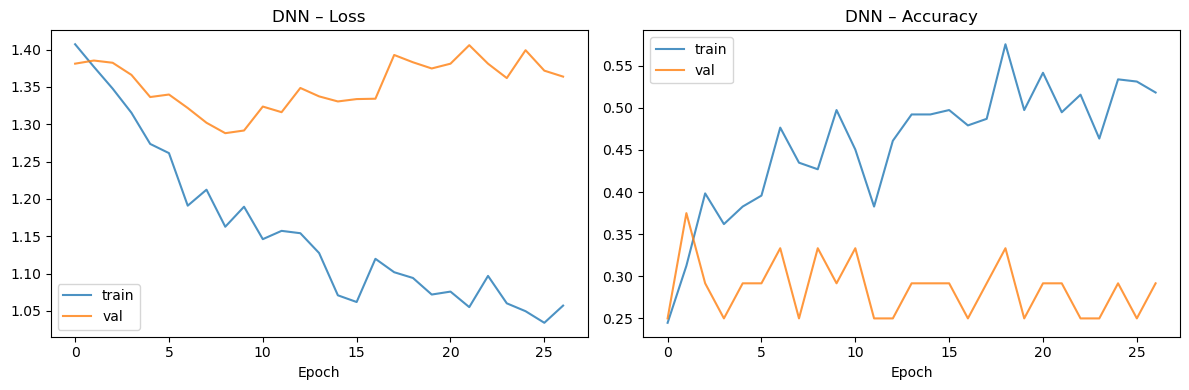

In [40]:
# Build and train DNN
torch.manual_seed(SEED)
dnn_model = DNN(input_dim, NUM_CLASSES)
print(dnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in dnn_model.parameters()):,}")
print("\nTraining DNN...")
dnn_model, dnn_history = train_model(dnn_model, train_loader, test_loader, "DNN")
plot_training_history(dnn_history, "DNN")

### 6.2 Train 1D-CNN

CNN_1D(
  (conv_block): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AdaptiveAvgPool1d(output_size=1)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)

Total parameters: 8,804

Training CNN_1D...
  Epoch  25/300 — loss: 1.2425 acc: 0.3516 — val_loss: 1.2489 val_acc: 0.2500 lr: 0.000096
  Early stopping at epoch 39 (best val_acc: 0.3750)
  ✓ Best val accuracy: 0.3750


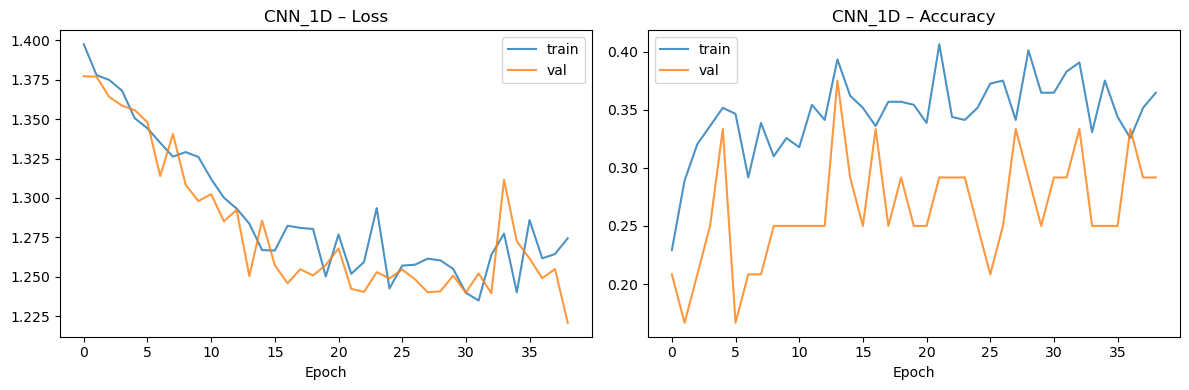

In [41]:
# Build and train 1D-CNN
torch.manual_seed(SEED)
cnn_model = CNN_1D(input_dim, NUM_CLASSES)
print(cnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")
print("\nTraining CNN_1D...")
cnn_model, cnn_history = train_model(cnn_model, train_loader, test_loader, "CNN_1D")
plot_training_history(cnn_history, "CNN_1D")

### 6.3 Train LSTM

LSTMModel(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (classifier): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=4, bias=True)
  )
)

Total parameters: 36,260

Training LSTM...
  Epoch  25/300 — loss: 1.2790 acc: 0.3828 — val_loss: 1.4096 val_acc: 0.2500 lr: 0.000096
  Early stopping at epoch 47 (best val_acc: 0.3333)
  ✓ Best val accuracy: 0.3333


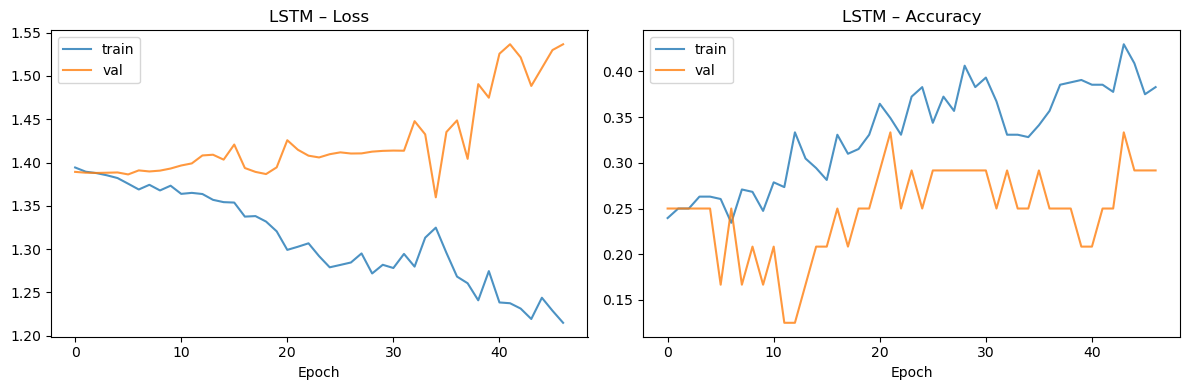

In [42]:
# Build and train LSTM
torch.manual_seed(SEED)
lstm_model = LSTMModel(input_dim, NUM_CLASSES)
print(lstm_model)
print(f"\nTotal parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")
print("\nTraining LSTM...")
lstm_model, lstm_history = train_model(lstm_model, train_loader, test_loader, "LSTM")
plot_training_history(lstm_history, "LSTM")

## 7. K-Fold Cross-Validation (on full data)
Run 5-fold stratified cross-validation on the entire dataset to get a more reliable accuracy estimate.

In [43]:
# ── K-Fold Cross-Validation for robust accuracy ──────────────────────
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

model_builders = {
    "DNN": lambda: DNN(input_dim, NUM_CLASSES),
    "CNN_1D": lambda: CNN_1D(input_dim, NUM_CLASSES),
    "LSTM": lambda: LSTMModel(input_dim, NUM_CLASSES),
}

cv_results = {name: [] for name in model_builders}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    print(f"\n{'='*50}")
    print(f"Fold {fold+1}/{N_FOLDS}")
    print(f"{'='*50}")

    X_tr_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_tr_fold, y_val_fold = y[train_idx], y[val_idx]

    # Augment training fold
    X_tr_aug, y_tr_aug = augment_data(X_tr_fold, y_tr_fold)

    # Create fold DataLoaders
    fold_train_ds = TensorDataset(
        torch.FloatTensor(X_tr_aug).to(device),
        torch.LongTensor(y_tr_aug).to(device)
    )
    fold_val_ds = TensorDataset(
        torch.FloatTensor(X_val_fold).to(device),
        torch.LongTensor(y_val_fold).to(device)
    )
    fold_train_loader = DataLoader(fold_train_ds, batch_size=BATCH_SIZE, shuffle=True)
    fold_val_loader = DataLoader(fold_val_ds, batch_size=BATCH_SIZE, shuffle=False)

    for name, builder in model_builders.items():
        torch.manual_seed(SEED + fold)
        model = builder()
        model, _ = train_model(model, fold_train_loader, fold_val_loader, f"{name}_fold{fold+1}", epochs=200, patience=30)

        model.eval()
        with torch.no_grad():
            val_t = torch.FloatTensor(X_val_fold).to(device)
            preds = model(val_t).argmax(1).cpu().numpy()
        fold_acc = accuracy_score(y_val_fold, preds)
        cv_results[name].append(fold_acc)
        print(f"  {name} fold {fold+1} accuracy: {fold_acc:.4f}")

print(f"\n{'='*60}")
print("Cross-Validation Results Summary:")
print(f"{'='*60}")
for name, accs in cv_results.items():
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    print(f"  {name:10s} → {mean_acc:.4f} ± {std_acc:.4f}  (folds: {[f'{a:.3f}' for a in accs]})")


Fold 1/5
  Epoch  25/200 — loss: 1.0772 acc: 0.4531 — val_loss: 1.3721 val_acc: 0.2917 lr: 0.000096
  Early stopping at epoch 38 (best val_acc: 0.4167)
  ✓ Best val accuracy: 0.4167
  DNN fold 1 accuracy: 0.4167
  Epoch  25/200 — loss: 1.2842 acc: 0.3932 — val_loss: 1.2409 val_acc: 0.2917 lr: 0.000096
  Epoch  50/200 — loss: 1.2083 acc: 0.3958 — val_loss: 1.2096 val_acc: 0.2917 lr: 0.000773
  Epoch  75/200 — loss: 1.1970 acc: 0.4089 — val_loss: 1.1444 val_acc: 0.3750 lr: 0.000166
  Early stopping at epoch 83 (best val_acc: 0.4583)
  ✓ Best val accuracy: 0.4583
  CNN_1D fold 1 accuracy: 0.4583
  Epoch  25/200 — loss: 1.3262 acc: 0.3255 — val_loss: 1.5703 val_acc: 0.2500 lr: 0.000096
  Early stopping at epoch 37 (best val_acc: 0.3750)
  ✓ Best val accuracy: 0.3750
  LSTM fold 1 accuracy: 0.3750

Fold 2/5
  Epoch  25/200 — loss: 1.0949 acc: 0.4609 — val_loss: 1.5115 val_acc: 0.3333 lr: 0.000096
  Epoch  50/200 — loss: 0.9917 acc: 0.5938 — val_loss: 1.6978 val_acc: 0.4167 lr: 0.000773
  E

## 8. Final Evaluation on Hold-out Test Set
Evaluate the models trained on the augmented 80% split against the 20% test set.


DNN Results:
  Test Accuracy:   0.3750
  Precision:       0.2493
  Recall:          0.3750
  F1-score:        0.2848
  CV Accuracy:     0.4000 ± 0.0565

              precision    recall  f1-score   support

     natural       0.46      1.00      0.63         6
    lowlevel       0.00      0.00      0.00         6
    midlevel       0.29      0.33      0.31         6
   highlevel       0.25      0.17      0.20         6

    accuracy                           0.38        24
   macro avg       0.25      0.38      0.28        24
weighted avg       0.25      0.38      0.28        24



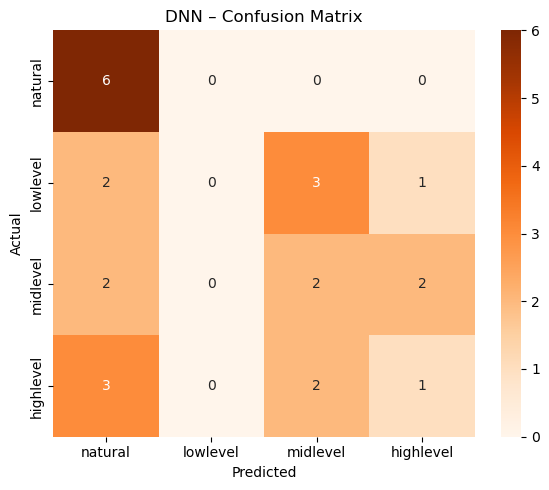


CNN_1D Results:
  Test Accuracy:   0.3750
  Precision:       0.3429
  Recall:          0.3750
  F1-score:        0.3476
  CV Accuracy:     0.4417 ± 0.0858

              precision    recall  f1-score   support

     natural       0.57      0.67      0.62         6
    lowlevel       0.00      0.00      0.00         6
    midlevel       0.50      0.33      0.40         6
   highlevel       0.30      0.50      0.38         6

    accuracy                           0.38        24
   macro avg       0.34      0.38      0.35        24
weighted avg       0.34      0.38      0.35        24



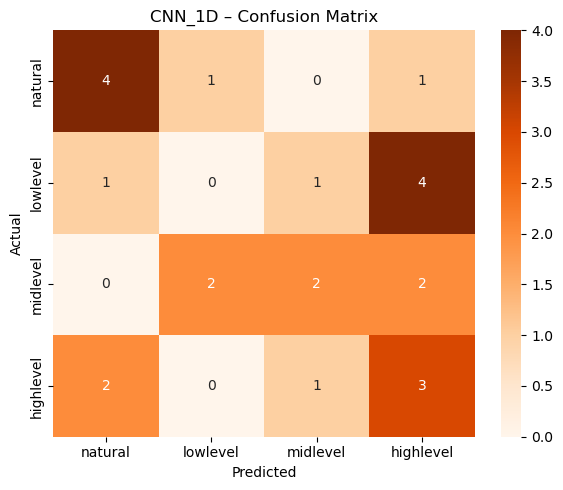


LSTM Results:
  Test Accuracy:   0.3333
  Precision:       0.2738
  Recall:          0.3333
  F1-score:        0.2821
  CV Accuracy:     0.3750 ± 0.0589

              precision    recall  f1-score   support

     natural       0.43      0.50      0.46         6
    lowlevel       0.00      0.00      0.00         6
    midlevel       0.33      0.67      0.44         6
   highlevel       0.33      0.17      0.22         6

    accuracy                           0.33        24
   macro avg       0.27      0.33      0.28        24
weighted avg       0.27      0.33      0.28        24



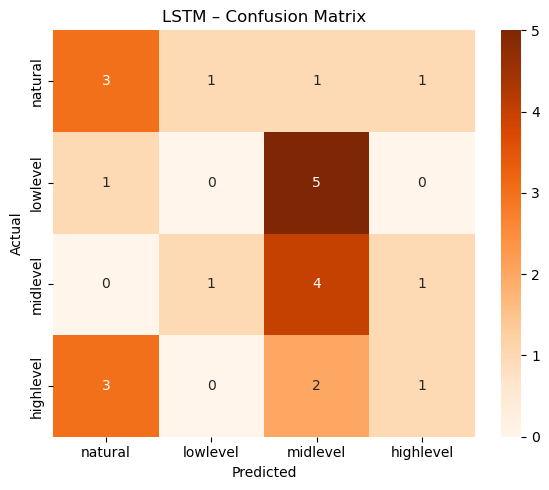

In [44]:
# Evaluate all models on hold-out test set
dl_models = {
    "DNN": dnn_model,
    "CNN_1D": cnn_model,
    "LSTM": lstm_model,
}

results = {}
for name, model in dl_models.items():
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_t)
        y_pred = outputs.argmax(1).cpu().numpy()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    # Add CV results as well
    cv_mean = np.mean(cv_results[name])
    cv_std = np.std(cv_results[name])

    results[name] = {
        "accuracy": round(acc, 4),
        "precision": round(prec, 4),
        "recall": round(rec, 4),
        "f1_score": round(f1, 4),
        "cv_accuracy_mean": round(cv_mean, 4),
        "cv_accuracy_std": round(cv_std, 4),
    }

    print(f"\n{'='*50}")
    print(f"{name} Results:")
    print(f"{'='*50}")
    print(f"  Test Accuracy:   {acc:.4f}")
    print(f"  Precision:       {prec:.4f}")
    print(f"  Recall:          {rec:.4f}")
    print(f"  F1-score:        {f1:.4f}")
    print(f"  CV Accuracy:     {cv_mean:.4f} ± {cv_std:.4f}")
    print(f"\n{classification_report(y_test, y_pred, target_names=STRESS_NAMES, zero_division=0)}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=STRESS_NAMES, yticklabels=STRESS_NAMES, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"{name} – Confusion Matrix")
    fig.tight_layout()
    fig.savefig(STATIC_DIR / f"cm_{name}.png", dpi=100)
    plt.show()


Results Summary:
        accuracy  precision  recall  f1_score  cv_accuracy_mean
DNN       0.3750     0.2493  0.3750    0.2848            0.4000
CNN_1D    0.3750     0.3429  0.3750    0.3476            0.4417
LSTM      0.3333     0.2738  0.3333    0.2821            0.3750


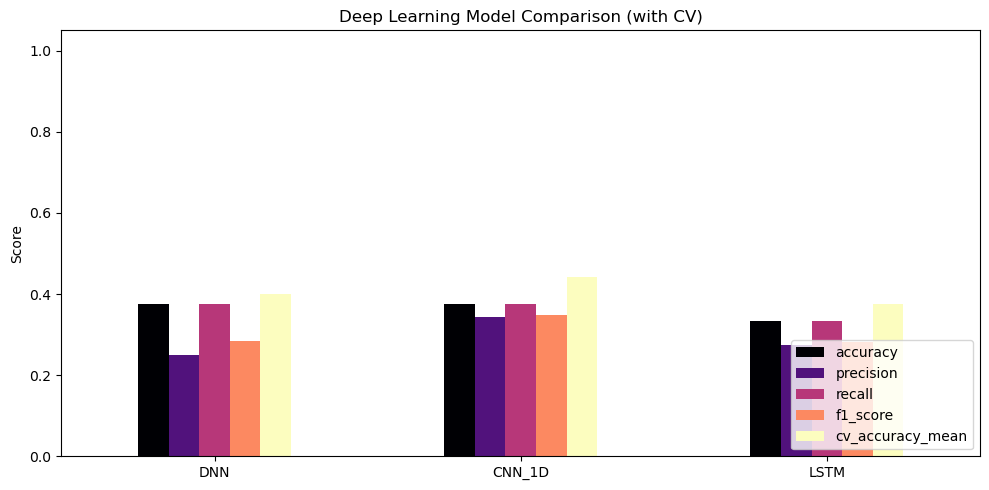

In [45]:
# Model comparison plot
res_df = pd.DataFrame(results).T
print("\nResults Summary:")
print(res_df[["accuracy", "precision", "recall", "f1_score", "cv_accuracy_mean"]])

fig, ax = plt.subplots(figsize=(10, 5))
res_df[["accuracy", "precision", "recall", "f1_score", "cv_accuracy_mean"]].plot(
    kind="bar", ax=ax, colormap="magma"
)
ax.set_ylabel("Score")
ax.set_title("Deep Learning Model Comparison (with CV)")
ax.set_ylim(0, 1.05)
ax.legend(loc="lower right")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
fig.tight_layout()
fig.savefig(STATIC_DIR / "dl_comparison.png", dpi=100)
plt.show()

## 9. Save Trained Models and Results

In [46]:
# Save all models (.pt format for PyTorch)
torch.save(dnn_model.state_dict(), str(MODEL_DIR / "dl_DNN.pt"))
torch.save(cnn_model.state_dict(), str(MODEL_DIR / "dl_CNN_1D.pt"))
torch.save(lstm_model.state_dict(), str(MODEL_DIR / "dl_LSTM.pt"))
print("Models saved to:", MODEL_DIR)

# Save results JSON (without numpy types)
results_save = {}
for name, r in results.items():
    results_save[name] = {k: float(v) for k, v in r.items()}

with open(ROOT / "dl_results.json", "w") as f:
    json.dump(results_save, f, indent=2)
print("Results saved to: dl_results.json")

# Final summary
print("\n" + "=" * 60)
print("DL Training Complete! (PyTorch – Improved)")
print("=" * 60)
for name, r in results.items():
    print(f"  {name:10s} → acc={r['accuracy']:.4f}  f1={r['f1_score']:.4f}  cv={r['cv_accuracy_mean']:.4f}±{r['cv_accuracy_std']:.4f}")

Models saved to: /home/noman/MyFiles/AI/Research Paper/raw_data/models
Results saved to: dl_results.json

DL Training Complete! (PyTorch – Improved)
  DNN        → acc=0.3750  f1=0.2848  cv=0.4000±0.0565
  CNN_1D     → acc=0.3750  f1=0.3476  cv=0.4417±0.0858
  LSTM       → acc=0.3333  f1=0.2821  cv=0.3750±0.0589
